In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


In [4]:
from fastbook import *

In [5]:
from PIL import Image

# img = Image.open("/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Stroke/58 (1).jpg")

**Stroke detection**

In [6]:
import glob
import pandas as pd
import numpy as np
from fastbook import *

# normal_imgs = glob.glob("/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Normal/*")
# stroke_imgs = glob.glob("/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/Stroke/*")


In [7]:
import requests

def download_file(url, filename='', headers=None, timeout=30, verify=True):
    """
    Downloads a file from the given URL and saves it to the current directory.
    Optionally, you can specify a filename to save it as.
    
    WARNING: Setting 'verify' to False bypasses SSL verification and is insecure.
    """
    if not filename:
        filename = url.split('/')[-1]
    if headers is None:
        headers = {'User-Agent': 'Mozilla/5.0'}

    with requests.get(url, headers=headers, stream=True, timeout=timeout, verify=verify) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return filename

# Correct URLs pointing to the raw CSV files
urls = [
    'https://raw.githubusercontent.com/FatimaAyub12/DCNN/main/test_stroke.csv',
    'https://raw.githubusercontent.com/FatimaAyub12/DCNN/main/train_stroke.csv'
]

for url in urls:
    # Set 'verify' to False ONLY for testing purposes and if you understand the risks
    filename = download_file(url, verify=False)
    print(f'Downloaded {filename}')



ConnectionError: HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /FatimaAyub12/DCNN/main/test_stroke.csv (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002D0E96259D0>: Failed to establish a new connection: [WinError 10049] The requested address is not valid in its context'))

In [8]:
import pandas as pd

# Attempt to read the CSV without specifying the number of columns, skipping the first row (header)
try:
    train_df = pd.read_csv("train_stroke.csv", header=None, skiprows=1)
    test_df = pd.read_csv("test_stroke.csv", header=None, skiprows=1)
    print("Files loaded successfully without header.")
except pd.errors.ParserError as e:
    print("Error loading files without header:", e)

# If the above fails, attempt to read the CSV, manually specifying the delimiter and quote character
try:
    train_df = pd.read_csv("train_stroke.csv", delimiter=',', quoting=1)
    test_df = pd.read_csv("test_stroke.csv", delimiter=',', quoting=1)
    print("Files loaded successfully with specified delimiter and quoting.")
except pd.errors.ParserError as e:
    print("Error loading files with specified delimiter and quoting:", e)


Files loaded successfully without header.
Files loaded successfully with specified delimiter and quoting.


In [9]:
def correct_path(kaggle_path):
    # Extract the filename and the subdirectory (Stroke or Normal)
    parts = kaggle_path.split('/')
    subdirectory = parts[-2]  # This should be 'Stroke' or 'Normal'
    filename = parts[-1]  # The actual filename
    
    # Construct the local path
    local_path = os.path.join(path_to_images, subdirectory, filename)
    return local_path

# Base path where images are stored
path_to_images = r'C:\Users\Sabir\Brain_Data_Organised'

# Apply the correction to both train_df and test_df
train_df['path'] = train_df['name'].apply(correct_path)
test_df['path'] = test_df['name'].apply(correct_path)

# Confirm the paths are corrected
print(train_df[['path', 'label']].head())
print(test_df[['path', 'label']].head())


                                                      path  label
0   C:\Users\Sabir\Brain_Data_Organised\Stroke\84 (39).jpg      1
1  C:\Users\Sabir\Brain_Data_Organised\Normal\114 (10).jpg      0
2   C:\Users\Sabir\Brain_Data_Organised\Stroke\92 (40).jpg      1
3    C:\Users\Sabir\Brain_Data_Organised\Normal\99 (7).jpg      0
4   C:\Users\Sabir\Brain_Data_Organised\Normal\65 (11).jpg      0
                                                     path  label
0  C:\Users\Sabir\Brain_Data_Organised\Normal\99 (24).jpg      0
1  C:\Users\Sabir\Brain_Data_Organised\Stroke\70 (19).jpg      1
2  C:\Users\Sabir\Brain_Data_Organised\Normal\118 (7).jpg      0
3  C:\Users\Sabir\Brain_Data_Organised\Normal\62 (22).jpg      0
4  C:\Users\Sabir\Brain_Data_Organised\Normal\54 (28).jpg      0


DCNN

In [10]:
from fastai.vision.all import *
import pandas as pd
import os

# Load the CSV files
train_df = pd.read_csv("train_stroke.csv")
test_df = pd.read_csv("test_stroke.csv")

# Function to correct the paths in the DataFrame
def correct_path(path):
    # Adjust the path format according to your local directory structure
    new_path = path.replace('/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/', '')
    return os.path.join('Brain_Data_Organised', new_path)

# Apply the correction
train_df['name'] = train_df['name'].apply(correct_path)
test_df['name'] = test_df['name'].apply(correct_path)

# Now proceed to create ImageDataLoaders with the corrected paths but with simplified transformations
data = ImageDataLoaders.from_df(train_df,
                                '.',
                                fn_col='name',
                                label_col='label',
                                item_tfms=Resize(224),
                                # Comment out or remove batch_tfms to avoid potential LAPACK-related errors
                                # batch_tfms=aug_transforms(),
                                valid_pct=0.1,
                                num_workers=4)
class DCNN(nn.Module):
    def __init__(self):
        super(DCNN, self).__init__()
        # Adjust the first convolutional layer to accept 3 input channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Define a max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Update the size according to your model architecture and input size
        self.fc2 = nn.Linear(512, 128)
        # Output layer
        self.fc3 = nn.Linear(128, 2)  # Assuming binary classification, adjust according to your number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the custom model
model = DCNN()

# Adjust the `n_out` parameter according to your dataset's number of classes
learn = Learner(data, model, metrics=[accuracy, Recall(), Precision(), F1Score()])

# Train the model
learn.fit_one_cycle(10)

# Evaluate the model
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()



epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.645461,0.623241,0.595556,0.061856,1.000000,0.116505,00:20
1,0.501247,0.938494,0.675556,0.247423,1.000000,0.396694,00:16
2,0.347174,0.185276,0.924444,0.845361,0.976190,0.906077,00:16
3,0.214230,0.148865,0.942222,0.876289,0.988372,0.928962,00:16
4,0.125564,0.059798,0.968889,0.948454,0.978723,0.963351,00:16
5,0.072663,0.057533,0.973333,0.948454,0.989247,0.968421,00:16
6,0.041285,0.046151,0.991111,0.979381,1.000000,0.989583,00:16
7,0.023055,0.044815,0.986667,0.979381,0.989583,0.984456,00:16
8,0.012959,0.044469,0.986667,0.979381,0.989583,0.984456,00:16
9,0.007526,0.044459,0.986667,0.979381,0.989583,0.984456,00:16


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       128
           1       0.99      0.98      0.98        97

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225



In [11]:
# Ensure your test_df is prepared similarly to train_df and has the correct image paths
# Create a test DataLoader
test_dl = data.test_dl(test_df, with_labels=True)

# Make predictions on the test set
preds, targets = learn.get_preds(dl=test_dl)

# Calculate the accuracy and other metrics on the test set
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Convert predictions to binary using argmax if your task is binary/multiclass classification
preds_binary = preds.argmax(dim=1)

# Assuming targets and preds_binary are tensors, convert them to numpy arrays if necessary
targets_np = targets.numpy()
preds_binary_np = preds_binary.numpy()

# Calculate metrics
accuracy = accuracy_score(targets_np, preds_binary_np)
recall = recall_score(targets_np, preds_binary_np, average='macro')  # adjust 'macro' as per your case
precision = precision_score(targets_np, preds_binary_np, average='macro')  # adjust 'macro' as per your case
f1 = f1_score(targets_np, preds_binary_np, average='macro')  # adjust 'macro' as per your case

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


Accuracy: 0.9721115537848606
Recall: 0.9703250427687854
Precision: 0.9718151815181518
F1 Score: 0.971052935070926


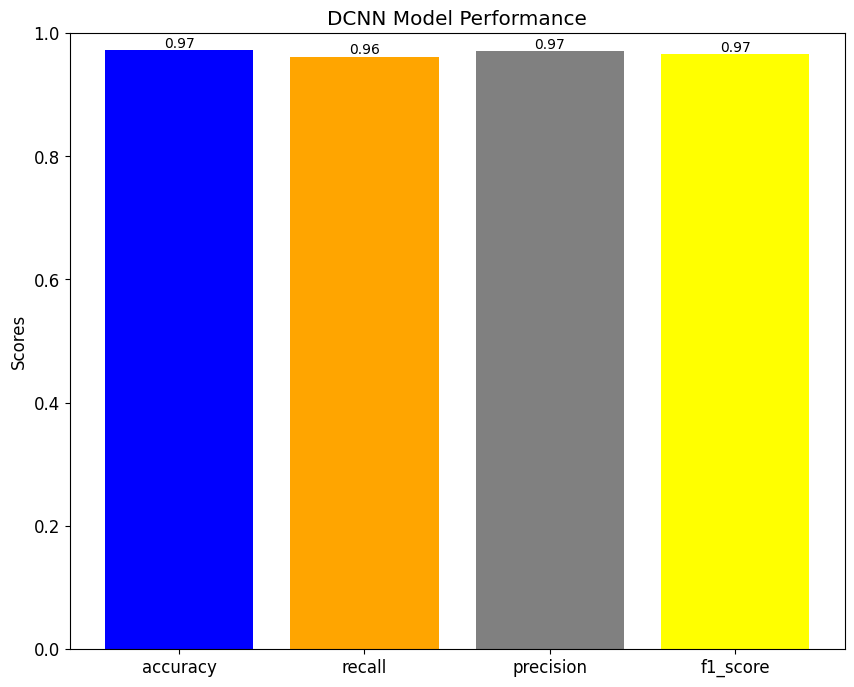

In [12]:
import matplotlib.pyplot as plt

# Check if there are recorded values after training
if len(learn.recorder.values) > 0:
    # Retrieve the last row of metrics
    last_metrics = learn.recorder.values[-1]
    
    # Extract the metrics directly based on the reported structure
    # Adjusting indices based on the structure: [train_loss, accuracy, recall, precision, f1_score]
    train_loss = last_metrics[0]  # Training loss
    accuracy_value = last_metrics[1]  # index for accuracy
    recall_value = last_metrics[2]    # index for recall
    precision_value = last_metrics[3]  # index for precision
    f1_score_value = last_metrics[4]   # index for f1_score

    # Define metric names for the plot, excluding 'train_loss'
    metrics_names = ['accuracy', 'recall', 'precision', 'f1_score']
    metrics_values = [accuracy_value, recall_value, precision_value, f1_score_value]
    colors = ['blue', 'orange', 'gray', 'yellow']

    # Create the bar chart
    plt.figure(figsize=(10, 8))
    bars = plt.bar(metrics_names, metrics_values, color=colors)

    # Annotate each bar with the value of the metric
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    plt.ylabel('Scores')
    plt.title('DCNN Model Performance')
    plt.ylim(0, 1)  # Assuming the metric scores are between 0 and 1

    # Show the plot
    plt.show()
else:
    print("No recorded values found. Ensure the model has been trained.")


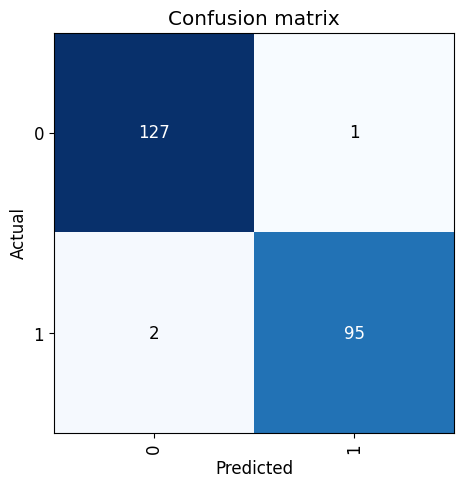

In [13]:
from fastai.interpret import ClassificationInterpretation,Interpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

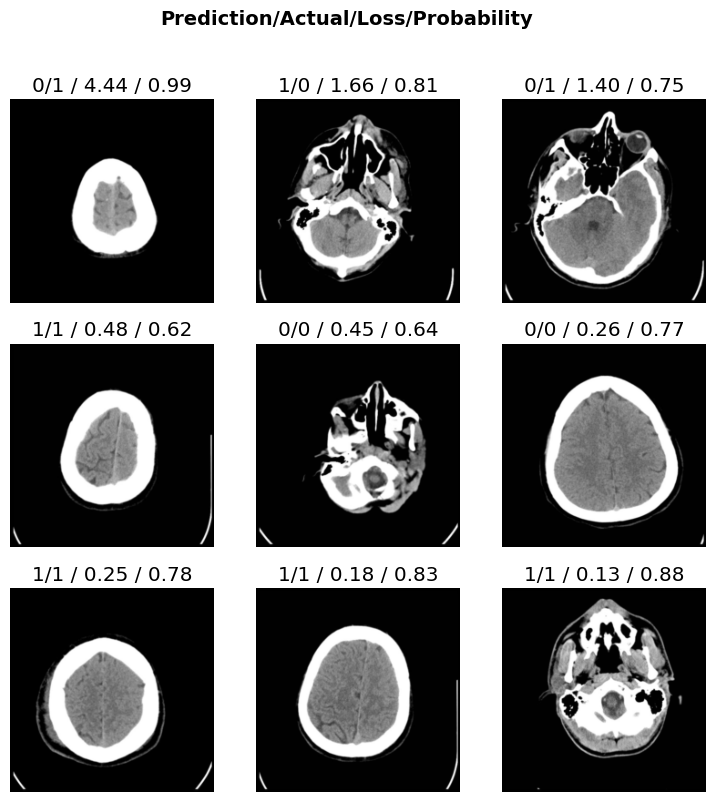

In [14]:
# from fastai.vision.learner import Interpretation

interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

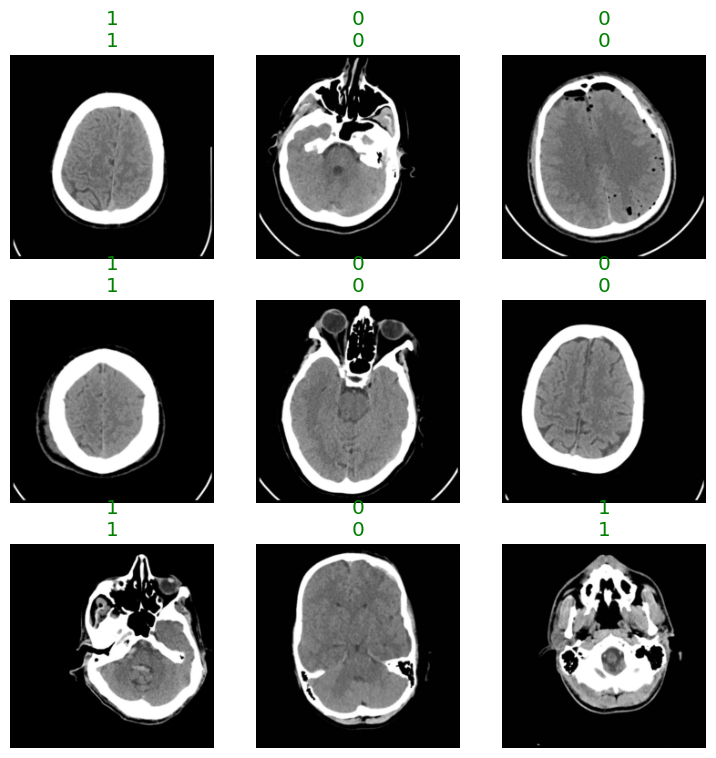

In [15]:
learn.show_results()

# VGG16

In [1]:
from fastai.vision.all import *
import pandas as pd
import os

# Load the CSV files
train_df = pd.read_csv("train_stroke.csv")
test_df = pd.read_csv("test_stroke.csv")

# Function to correct the paths in the DataFrame
def correct_path(path):
    # Adjust the path format according to your local directory structure
    new_path = path.replace('/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/', '')
    return os.path.join('Brain_Data_Organised', new_path)

# Apply the correction
train_df['name'] = train_df['name'].apply(correct_path)
test_df['name'] = test_df['name'].apply(correct_path)

# Now proceed to create ImageDataLoaders with the corrected paths but with simplified transformations
data = ImageDataLoaders.from_df(train_df,
                                '.',
                                fn_col='name',
                                label_col='label',
                                item_tfms=Resize(224),
                                # Comment out or remove batch_tfms to avoid potential LAPACK-related errors
                                # batch_tfms=aug_transforms(),
                                valid_pct=0.1,
                                num_workers=4)

# Specify the correct metrics
metrics = [accuracy, Recall(), Precision(), F1Score()]

learn = cnn_learner(data, models.vgg16_bn, metrics=metrics)

learn.fit_one_cycle(10)

interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()


C:\Users\Sabir\anaconda3\envs\pytorch\lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,1.223984,0.721058,0.617778,0.779070,0.500000,0.609091,10:41
1,0.900346,0.432346,0.831111,0.837209,0.750000,0.791209,10:33
2,0.665604,0.376169,0.840000,0.709302,0.847222,0.772152,10:32
3,0.468089,0.241813,0.884444,0.895349,0.819149,0.855556,10:33
4,0.330819,0.294310,0.897778,0.883721,0.853933,0.868571,10:32
5,0.242092,0.247944,0.897778,0.883721,0.853933,0.868571,10:34
6,0.183636,0.160594,0.946667,0.918605,0.940476,0.929412,10:35
7,0.134404,0.163649,0.951111,0.930233,0.941176,0.935673,10:36
8,0.104500,0.148782,0.955556,0.953488,0.931818,0.942529,10:38
9,0.089669,0.149427,0.951111,0.941860,0.931034,0.936416,10:35


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       139
           1       0.93      0.94      0.94        86

    accuracy                           0.95       225
   macro avg       0.95      0.95      0.95       225
weighted avg       0.95      0.95      0.95       225



In [18]:
# Ensure your test_df is prepared similarly to train_df and has the correct image paths

# Create a test DataLoader
test_dl = data.test_dl(test_df, with_labels=True)

# Make predictions on the test set
preds, targets = learn.get_preds(dl=test_dl)

# Calculate the accuracy and other metrics on the test set
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Convert predictions to binary using argmax if your task is binary/multiclass classification
preds_binary = preds.argmax(dim=1)

# Assuming targets and preds_binary are tensors, convert them to numpy arrays if necessary
targets_np = targets.numpy()
preds_binary_np = preds_binary.numpy()

# Calculate metrics
accuracy = accuracy_score(targets_np, preds_binary_np)
recall = recall_score(targets_np, preds_binary_np, average='macro')  # adjust 'macro' as per your case
precision = precision_score(targets_np, preds_binary_np, average='macro')  # adjust 'macro' as per your case
f1 = f1_score(targets_np, preds_binary_np, average='macro')  # adjust 'macro' as per your case

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


Accuracy: 0.9442231075697212
Recall: 0.9452888537965521
Precision: 0.940305790500976
F1 Score: 0.94253663003663


[0.16637615859508514, 0.9442231059074402, 0.9509803921568627, 0.9150943396226415, 0.9326923076923077]


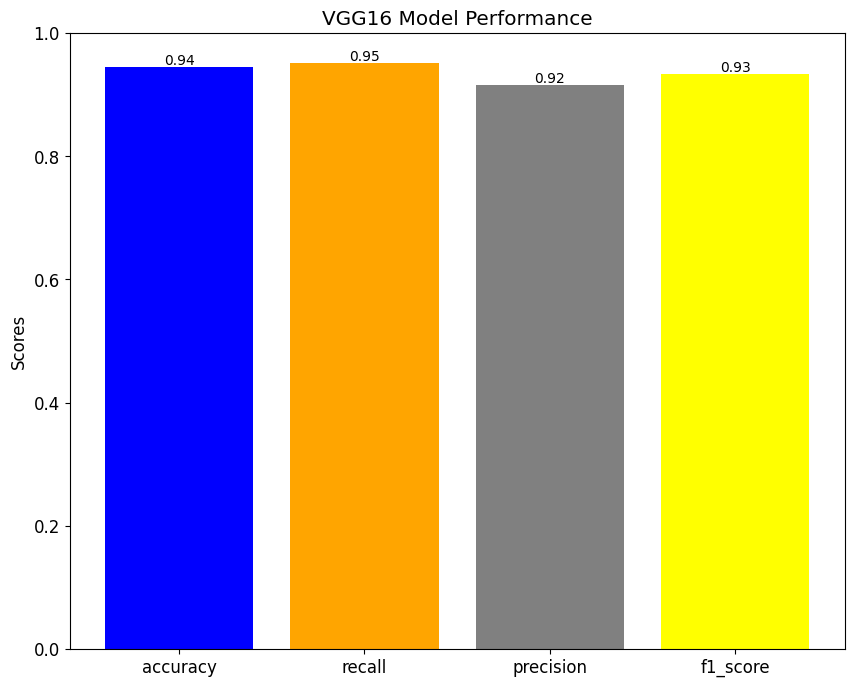

In [19]:
import matplotlib.pyplot as plt

# Check if there are recorded values
if len(learn.recorder.values) > 0:  # Ensure there are metrics recorded
    # Print the last recorded metrics to confirm their values
    print(learn.recorder.values[-1])

    # Define the positions of the metrics in the list, excluding error_rate
    metric_positions = {
        'accuracy': -4,  # Now at -4 because we're excluding error_rate
        'recall': -3,
        'precision': -2,
        'f1_score': -1
    }

    # Retrieve the last row of metrics
    last_metrics = learn.recorder.values[-1]

    # Extract the values for each metric using the positions defined
    metrics_values = [last_metrics[metric_positions[metric]] for metric in metric_positions if metric != 'error_rate']

    # Define metric names for the plot, excluding 'error_rate'
    metrics_names = [metric for metric in metric_positions if metric != 'error_rate']

    # Create the bar chart
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'orange', 'gray', 'yellow']  # Colors for each metric, excluding the color for error_rate
    bars = plt.bar(metrics_names, metrics_values, color=colors)

    # Annotate each bar with the value of the metric
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    plt.ylabel('Scores')
    plt.title('VGG16 Model Performance')
    plt.ylim(0, 1)  # Assuming your metrics are between 0 and 1

    # Show the plot
    plt.show()
else:
    print("No recorded values found. Has the model been trained and metrics been recorded?")



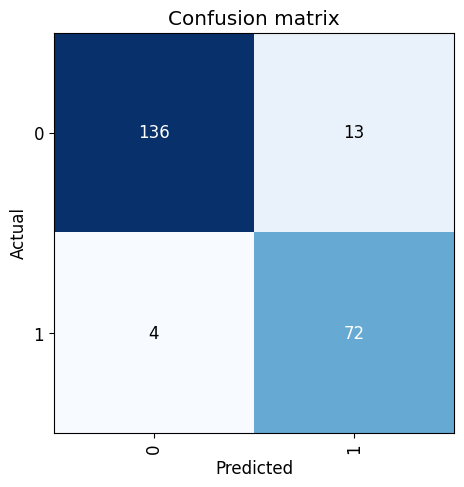

In [20]:
interp.plot_confusion_matrix()

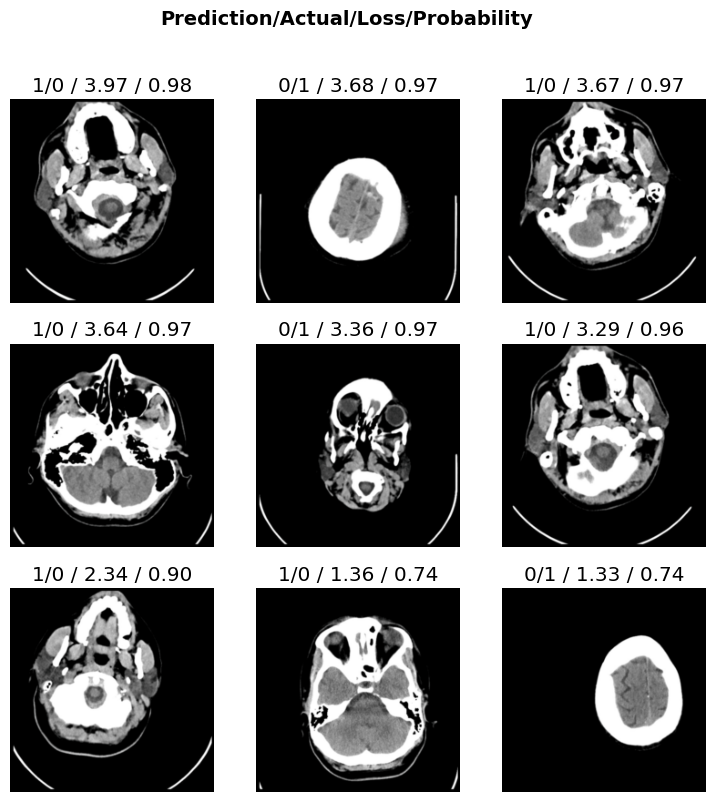

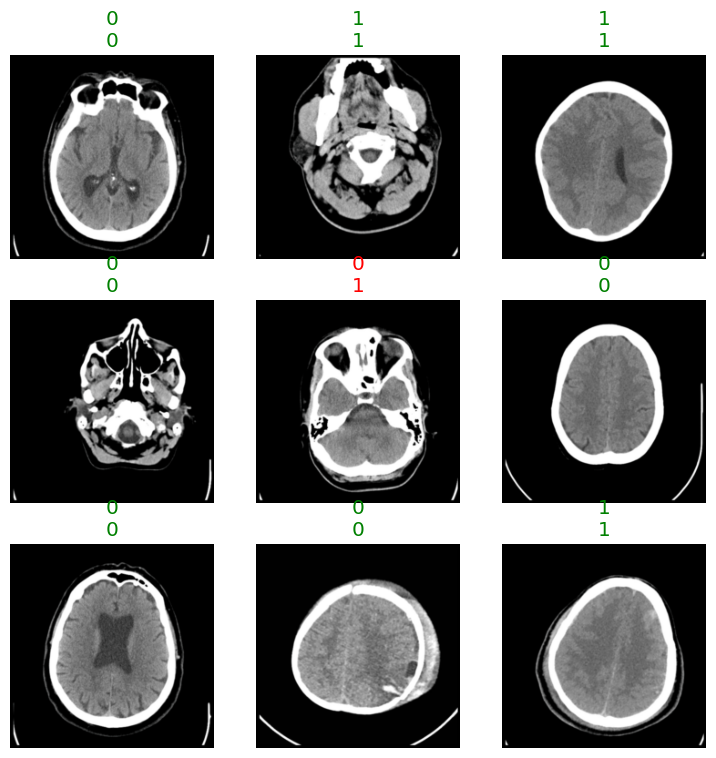

In [22]:
interp.plot_top_losses(9)
learn.show_results()


# ResNet50

C:\Users\Sabir\anaconda3\envs\pytorch\lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,1.140286,1.012720,0.648889,0.109756,0.600000,0.185567,03:25
1,0.836504,0.575892,0.755556,0.621951,0.680000,0.649682,03:20
2,0.620320,0.372929,0.844444,0.841463,0.758242,0.797688,03:20
3,0.457123,0.331300,0.862222,0.780488,0.831169,0.805031,03:20
4,0.327049,0.319244,0.875556,0.890244,0.793478,0.839080,03:20
5,0.239882,0.306814,0.871111,0.829268,0.819277,0.824242,03:21
6,0.176341,0.276315,0.902222,0.865854,0.865854,0.865854,03:21
7,0.137735,0.273078,0.888889,0.841463,0.851852,0.846626,03:39
8,0.110351,0.270704,0.888889,0.841463,0.851852,0.846626,03:38
9,0.088705,0.270071,0.880000,0.829268,0.839506,0.834356,04:48


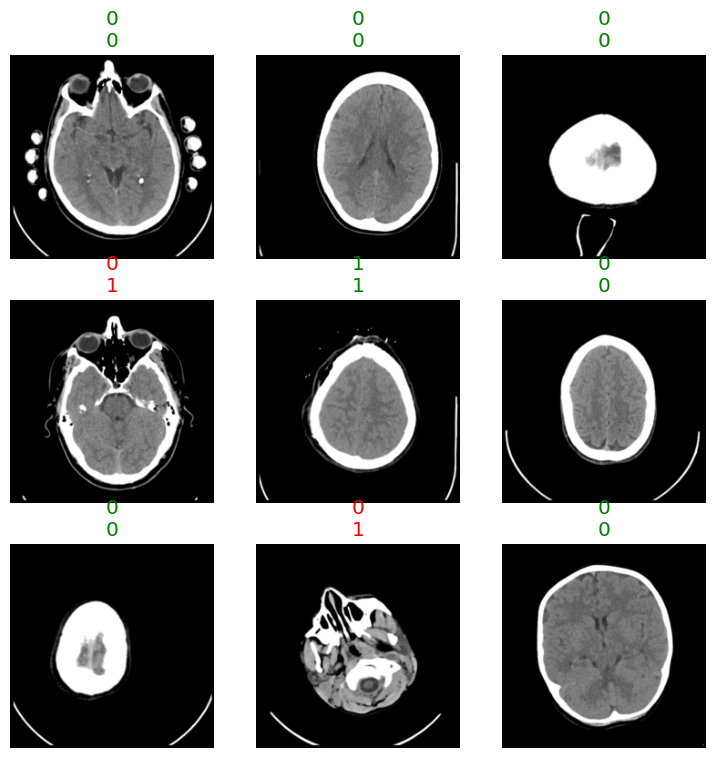

In [21]:
from fastai.vision.all import *
from fastai.vision.all import *
import pandas as pd
import os

# Assuming the CSV files are now in the same directory, not in '/kaggle/working'
train_df = pd.read_csv("train_stroke.csv")
test_df = pd.read_csv("test_stroke.csv")

# Correct the paths in the DataFrame, similar to the previous example
def correct_path(path):
    # Adjust according to the original dataset structure
    new_path = path.replace('/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/', '')
    return os.path.join('Brain_Data_Organised', new_path)

# Apply the correction
train_df['name'] = train_df['name'].apply(correct_path)
test_df['name'] = test_df['name'].apply(correct_path)

# Create ImageDataLoaders with corrected paths
data = ImageDataLoaders.from_df(train_df,
                                '.',
                                fn_col='name',
                                label_col='label',
                                item_tfms=Resize(224),
                                # Keep batch transformations if LAPACK error is resolved, otherwise comment out
                                #batch_tfms=aug_transforms(),
                                valid_pct=0.1,
                                num_workers=4)

# Correct 'presc' to 'Precision' and ensure metrics are properly referenced
metrics = [accuracy, Recall(), Precision(), F1Score()]

# Initialize the learner with the ResNet50 model
learn = cnn_learner(data, models.resnet50, metrics=metrics)

# Train the model
learn.fit_one_cycle(10)
learn.show_results()


In [23]:
# Ensure your test_df is prepared similarly to train_df and has the correct image paths

# Create a test DataLoader
test_dl = data.test_dl(test_df, with_labels=True)

# Make predictions on the test set
preds, targets = learn.get_preds(dl=test_dl)

# Calculate the accuracy and other metrics on the test set
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Convert predictions to binary using argmax if your task is binary/multiclass classification
preds_binary = preds.argmax(dim=1)

# Assuming targets and preds_binary are tensors, convert them to numpy arrays if necessary
targets_np = targets.numpy()
preds_binary_np = preds_binary.numpy()

# Calculate metrics
accuracy = accuracy_score(targets_np, preds_binary_np)
recall = recall_score(targets_np, preds_binary_np, average='macro')  # adjust 'macro' as per your case
precision = precision_score(targets_np, preds_binary_np, average='macro')  # adjust 'macro' as per your case
f1 = f1_score(targets_np, preds_binary_np, average='macro')  # adjust 'macro' as per your case

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


Accuracy: 0.9243027888446215
Recall: 0.9207790498749835
Precision: 0.9221122112211222
F1 Score: 0.9214293951925137


[0.2360205501317978, 0.9243028163909912, 0.9019607843137255, 0.9108910891089109, 0.9064039408866996]


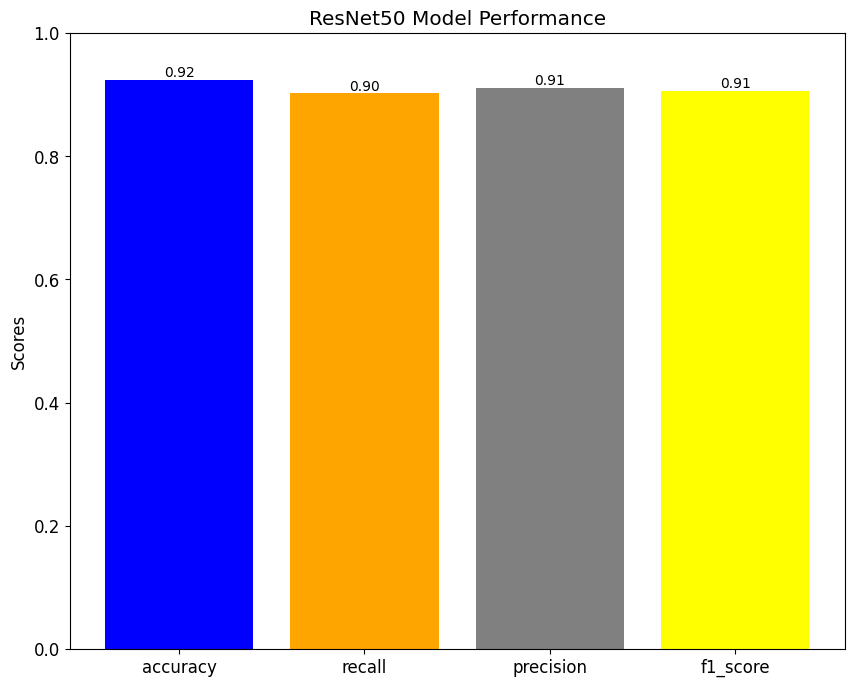

In [24]:

import matplotlib.pyplot as plt

# Make sure 'learn' is defined and the model has been trained
if len(learn.recorder.values) > 0:  # Check if there are recorded values
    # Print the last recorded metrics to confirm their values
    print(learn.recorder.values[-1])

    # Define the positions of the metrics in the list, excluding error_rate
    metric_positions = {
        'accuracy': -4,  # Assuming valid_loss is included, this is the position for accuracy
        'recall': -3,    # Assuming valid_loss is included, this is the position for recall
        'precision': -2, # Assuming valid_loss is included, this is the position for precision
        'f1_score': -1   # Assuming valid_loss is included, this is the position for f1_score
    }

    # Retrieve the last row of metrics
    last_metrics = learn.recorder.values[-1]

    # Extract the values for each metric using the positions defined
    metrics_values = [last_metrics[metric_positions[metric]] for metric in metric_positions]

    # Define metric names for the plot, excluding 'error_rate'
    metrics_names = [metric for metric in metric_positions]

    # Create the bar chart
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'orange', 'gray', 'yellow']  # Colors for each metric
    bars = plt.bar(metrics_names, metrics_values, color=colors)

    # Annotate each bar with the value of the metric
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    plt.ylabel('Scores')
    plt.title('ResNet50 Model Performance')
    plt.ylim(0, 1)  # Assuming your metrics are between 0 and 1

    # Show the plot
    plt.show()
else:
    print("No recorded values found. Has the model been trained and metrics been recorded?")



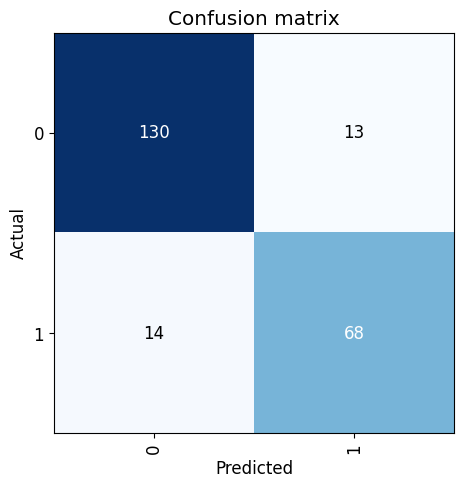

In [25]:
from fastai.interpret import ClassificationInterpretation,Interpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


# Incpetion v3

C:\Users\Sabir\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Sabir\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,0.677130,0.625960,0.662222,0.592593,0.527473,0.558140,03:15
1,0.643661,0.830360,0.546667,0.802469,0.430464,0.560345,03:11
2,0.613609,0.803422,0.622222,0.950617,0.487342,0.644351,03:11
3,0.590731,0.526906,0.791111,0.641975,0.742857,0.688742,03:11
4,0.567430,0.711414,0.604444,0.962963,0.475610,0.636735,03:11
5,0.536841,0.516692,0.755556,0.444444,0.782609,0.566929,03:11
6,0.508858,0.404924,0.857778,0.802469,0.802469,0.802469,03:11
7,0.478999,0.387848,0.871111,0.703704,0.919355,0.797203,03:11
8,0.441553,0.344437,0.902222,0.913580,0.831461,0.870588,03:12
9,0.421574,0.348574,0.880000,0.913580,0.787234,0.845714,03:11


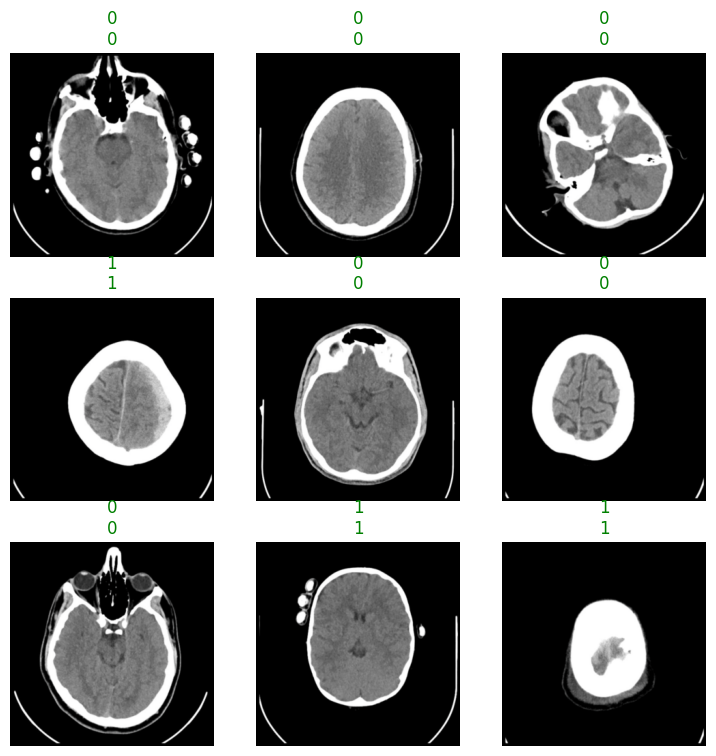

In [1]:
from fastai.vision.all import *
import pandas as pd
import os
from torchvision.models import inception_v3

def correct_path(path):
    new_path = path.replace('/kaggle/input/brain-stroke-ct-image-dataset/Brain_Data_Organised/', '')
    return os.path.join('Brain_Data_Organised', new_path)

class CustomInceptionV3(nn.Module):
    def __init__(self, num_classes=2, pretrained=True, dropout_p=0.5):  # Adjusted dropout rate
        super().__init__()
        self.inception = inception_v3(pretrained=pretrained)
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, num_classes)
        self.dropout = nn.Dropout(dropout_p)
        
    def forward(self, x):
        if self.training:
            x, aux = self.inception(x)
            x = self.dropout(x)
            return x
        else:
            x = self.inception(x)
            return x

train_df = pd.read_csv("train_stroke.csv")
test_df = pd.read_csv("test_stroke.csv")
train_df['name'] = train_df['name'].apply(correct_path)
test_df['name'] = test_df['name'].apply(correct_path)

# Adjusted data augmentation complexity
batch_tfms = [*aug_transforms(mult=1, max_rotate=15, max_zoom=1.05, max_warp=0.1, p_affine=0.75, p_lighting=0.75), Normalize.from_stats(*imagenet_stats)]

data = ImageDataLoaders.from_df(
    train_df,
    '.',
    fn_col='name',
    label_col='label',
    item_tfms=Resize(299),
    batch_tfms=batch_tfms,
    valid_pct=0.1,
    num_workers=4
)

model = CustomInceptionV3(num_classes=data.c, pretrained=True, dropout_p=0.5)  # Use adjusted dropout

learn = Learner(
    data,
    model,
    metrics=[accuracy, Recall(), Precision(), F1Score()],
    loss_func=LabelSmoothingCrossEntropy(),
    wd=0.15  # Adjusted weight decay
)

learn.fit_one_cycle(10, 1e-3)
learn.show_results()




In [3]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Ensure test_df is prepared with the correct image paths
test_dl = data.test_dl(test_df, with_labels=True)

# Make predictions on the test set
preds, targs = learn.get_preds(dl=test_dl)

# Use argmax to get the predicted class if your output is logits (raw activations)
preds_class = preds.argmax(dim=1)

# Calculate metrics
accuracy = accuracy_score(targs.numpy(), preds_class.numpy())
recall = recall_score(targs.numpy(), preds_class.numpy(), average='macro')
precision = precision_score(targs.numpy(), preds_class.numpy(), average='macro')
f1 = f1_score(targs.numpy(), preds_class.numpy(), average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


Accuracy: 0.9282868525896414
Recall: 0.9287735228319516
Precision: 0.9239752765126871
F1 Score: 0.9261185243328102


[0.33136820793151855, 0.9282868504524231, 0.9313725490196079, 0.8962264150943396, 0.9134615384615385]


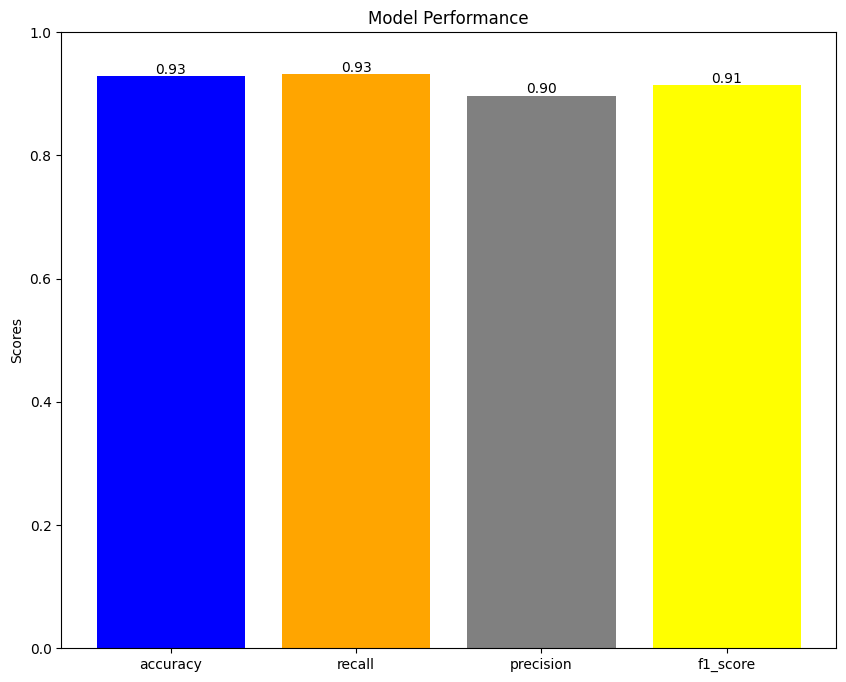

In [4]:
import matplotlib.pyplot as plt

# Assuming 'learn' is defined and the model has been trained

# Print the last recorded metrics to confirm their values
print(learn.recorder.values[-1])

# Assuming the structure is as follows [epoch, train_loss, valid_loss, accuracy, error_rate, recall, precision, f1_score]
# We will extract metrics based on this structure, excluding error_rate

# Define the positions of the metrics in the list, excluding error_rate
metric_positions = {
    'accuracy': -4,  # Now at -4 because we're excluding error_rate
    'recall': -3,
    'precision': -2,
    'f1_score': -1
}

# Retrieve the last row of metrics
last_metrics = learn.recorder.values[-1]

# Extract the values for each metric using the positions defined
metrics_values = [last_metrics[metric_positions[metric]] for metric in metric_positions]

# Define metric names for the plot, excluding 'error_rate'
metrics_names = [metric for metric in metric_positions if metric != 'error_rate']

# Create the bar chart
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'gray', 'yellow']  # Colors for each metric, excluding the color for error_rate
bars = plt.bar(metrics_names, metrics_values, color=colors)

# Annotate each bar with the value of the metric
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

# Add some text for labels, title, and custom x-axis tick labels, etc.
plt.ylabel('Scores')
plt.title('Model Performance')
plt.ylim(0, 1)  # Assuming your metrics are between 0 and 1

# Show the plot
plt.show()



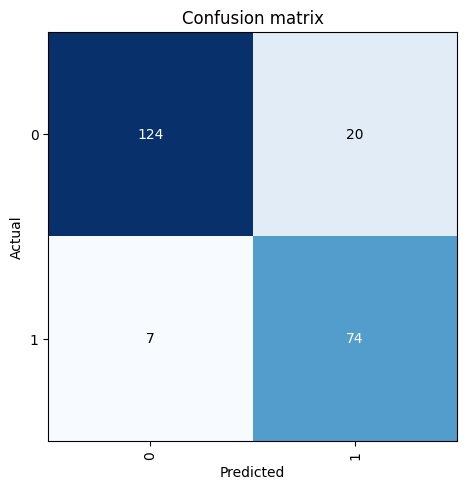

In [6]:
from fastai.interpret import ClassificationInterpretation,Interpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
